# Load Data



## Set env variables

assumes that `SOCRATA_APP_TOKEN`, `SOCRATA_API_KEY_ID`, and `SOCRATA_API_KEY_SECRET` are set in `.env`

In [1]:
from dotenv import load_dotenv

load_dotenv()


True

## Load Packages

In [2]:
import os
import sys

INGESTION_PATH = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, INGESTION_PATH)

from ingestion import fetch
from ingestion import config



In [68]:
import polars as pl
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, date

## Load Data

In [4]:
data_path = Path("../data/landing/311-service-requests")

lf = pl.scan_parquet(
    str(data_path / "**/*.parquet"),
    hive_partitioning=True,
)

## Subset Data to DOHMH

In [ ]:
# Filter for DOHMH agency and add derived columns
dohmh_data_only = lf.filter(pl.col("agency") == "DOHMH").select([
    "due_date",
    "landmark",
    "intersection_street_1",
    "intersection_street_2",
    "facility_type",
    "cross_street_2",
    "cross_street_1",
    "bbl",
    "location_type",
    "street_name",
    "incident_address",
    "address_type",
    "longitude",
    "latitude",
    "x_coordinate_state_plane",
    "y_coordinate_state_plane",
    "city",
    "incident_zip",
    "resolution_description",
    "closed_date",
    "resolution_action_updated_date",
    "descriptor",
    "community_board",
    "park_borough",
    "borough",
    "unique_key",
    "created_date",
    "agency_name",
    "agency",
    "complaint_type",
    "status",
    "open_data_channel_type",
    "park_facility_name",
    "year",
    "month"
]).collect()

df_orig = dohmh_data_only.to_pandas()

## Data Cleanup

### Fill Rates

In [39]:
# Plot missing values by column (similar to the reference image)
missing_counts = df_orig.isnull().sum().sort_values(ascending=False)
missing_counts = missing_counts[missing_counts > 0]  # Only show columns with missing values

# Calculate percentages for display
missing_percentages = (missing_counts / len(df_orig) * 100).round(1)

fig = go.Figure()

# Create bar chart
fig.add_trace(go.Bar(
    x=list(range(len(missing_counts))),
    y=missing_counts.values,
    text=[f'{pct}%' for pct in missing_percentages.values],
    textposition='outside',
    textangle=0,
    showlegend=False
))

# Update layout to match the reference style
fig.update_layout(
    title='Missing Values by Column',
    xaxis_title='Column',
    yaxis_title='Number of Missing Values',
    xaxis=dict(
        tickmode='array',
        tickvals=list(range(len(missing_counts))),
        ticktext=missing_counts.index,
        tickangle=-45
    ),
    height=600,
    margin=dict(b=120)  # Extra bottom margin for rotated labels
)

fig.show()


In [9]:
# Calculate overall fill rates
df_fill_rates = pd.DataFrame({
    'overall': df_orig.notna().sum() / len(df_orig)
}).round(3)

# Fill rates by borough
df_fill_rates_borough = df_orig.groupby('borough').apply(lambda x: x.notna().sum() / len(x)).round(3)
df_fill_rates_borough.insert(0, 'total_count', df_orig.groupby('borough').size())

# Fill rates by complaint_type
df_fill_rates_complaint = df_orig.groupby('complaint_type').apply(lambda x: x.notna().sum() / len(x)).round(3)
df_fill_rates_complaint.insert(0, 'total_count', df_orig.groupby('complaint_type').size())

# Plot 1: Borough fill rates vs overall
fig1 = go.Figure()
for borough in df_fill_rates_borough.index:
    borough_data = df_fill_rates_borough.loc[borough]
    overall_data = df_fill_rates['overall']
    
    # Get matching columns (excluding total_count)
    common_cols = [col for col in borough_data.index if col in overall_data.index and col != 'total_count']
    
    fig1.add_trace(go.Scatter(
        x=overall_data[common_cols],
        y=borough_data[common_cols],
        mode='markers',
        name=borough,
        text=common_cols,
        hovertemplate='%{text}<br>Overall: %{x}<br>' + f'{borough}: %{{y}}<extra></extra>'
    ))

fig1.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Perfect Match',
    line=dict(dash='dash', color='gray')
))

fig1.update_layout(
    title='Borough Fill Rates vs Overall Fill Rates',
    xaxis_title='Overall Fill Rate',
    yaxis_title='Borough Fill Rate',
    showlegend=True
)
fig1.show()

# Plot 2: Complaint type fill rates vs overall (top 20 by count)
top_complaints = df_fill_rates_complaint.nlargest(20, 'total_count')

fig2 = go.Figure()
for complaint in top_complaints.index:
    complaint_data = top_complaints.loc[complaint]
    overall_data = df_fill_rates['overall']
    
    # Get matching columns (excluding total_count)
    common_cols = [col for col in complaint_data.index if col in overall_data.index and col != 'total_count']
    
    fig2.add_trace(go.Scatter(
        x=overall_data[common_cols],
        y=complaint_data[common_cols],
        mode='markers',
        name=complaint,
        text=common_cols,
        hovertemplate='%{text}<br>Overall: %{x}<br>' + f'{complaint}: %{{y}}<extra></extra>'
    ))

fig2.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    name='Perfect Match',
    line=dict(dash='dash', color='gray')
))

fig2.update_layout(
    title='Top 20 Complaint Types Fill Rates vs Overall Fill Rates',
    xaxis_title='Overall Fill Rate',
    yaxis_title='Complaint Type Fill Rate',
    showlegend=True
)
fig2.show()


C:\Users\gorav\AppData\Local\Temp\ipykernel_13396\1177816533.py:7: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

C:\Users\gorav\AppData\Local\Temp\ipykernel_13396\1177816533.py:11: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



### CLosing Date Checks

In [17]:
df_orig[['created_date', 'due_date', 'closed_date', 'resolution_action_updated_date']].head()

,created_date,due_date,closed_date,resolution_action_updated_date
0,2010-01-01 08:20:22,2010-02-07 08:20:22,NaT,2010-01-04 11:38:30
1,2010-01-01 08:29:58,2010-01-31 08:29:58,NaT,2010-01-01 08:37:34
2,2010-01-01 09:59:50,2010-02-07 09:59:50,1900-01-01 00:00:00,2010-01-04 16:37:31
3,2010-01-01 10:35:38,2010-01-15 10:35:38,NaT,2010-01-15 07:37:07
4,2010-01-01 10:43:52,2010-01-31 10:43:52,2010-01-14 10:51:48,2010-01-14 10:51:48


In [18]:
df_orig[['created_date', 'due_date', 'closed_date', 'resolution_action_updated_date']].notna().sum() / len(df_orig)

created_date                      1.000000
due_date                          0.519628
closed_date                       0.866535
resolution_action_updated_date    0.956461
dtype: float64

In [91]:
# Calculate time to resolution (closed_date - created_date)
df_temp = df_orig.copy()
df_temp['time_to_resolution'] = df_temp['closed_date'] - df_temp['created_date']
df_temp['time_closed_to_resolution_update'] = df_temp['resolution_action_updated_date'] - df_temp['closed_date']
# Create flags in df_temp for data quality checks
df_temp['closed_before_created'] = df_temp['time_to_resolution'] < pd.Timedelta(0)
df_temp['identical_created_closed_dates'] = df_temp['time_to_resolution'] == pd.Timedelta(0)
df_temp['created_at_midnight'] = df_temp['created_date'].dt.time == pd.Timestamp('00:00:00').time()
df_temp['closed_at_midnight'] = df_temp['closed_date'].dt.time == pd.Timestamp('00:00:00').time()

# Calculate percentages for reporting
total_rows = len(df_temp)
pct_closed_before_created = (df_temp['closed_before_created'].sum() / total_rows) * 100
pct_identical_dates = (df_temp['identical_created_closed_dates'].sum() / total_rows) * 100
pct_created_midnight = (df_temp['created_at_midnight'].sum() / total_rows) * 100
pct_closed_midnight = (df_temp['closed_at_midnight'].sum() / total_rows) * 100

print("Data Quality Summary:")
print(f"Total rows: {total_rows:,}")
print(f"Percent closed before created date: {pct_closed_before_created:.2f}%")
print(f"Percent with identical created and closed dates: {pct_identical_dates:.2f}%")
print(f"Percent created at midnight: {pct_created_midnight:.2f}%")
print(f"Percent closed at midnight: {pct_closed_midnight:.2f}%")

Data Quality Summary:
Total rows: 1,030,037
Percent closed before created date: 0.64%
Percent with identical created and closed dates: 20.37%
Percent created at midnight: 28.16%
Percent closed at midnight: 22.59%


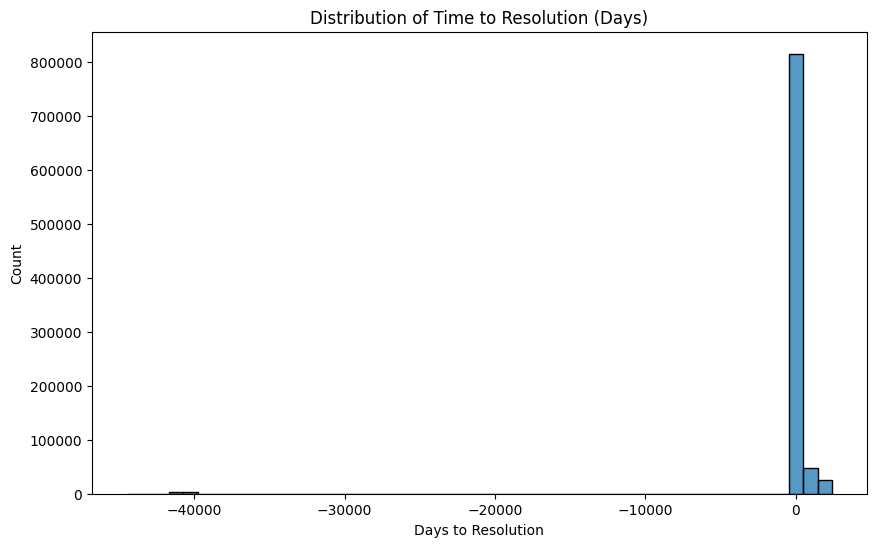

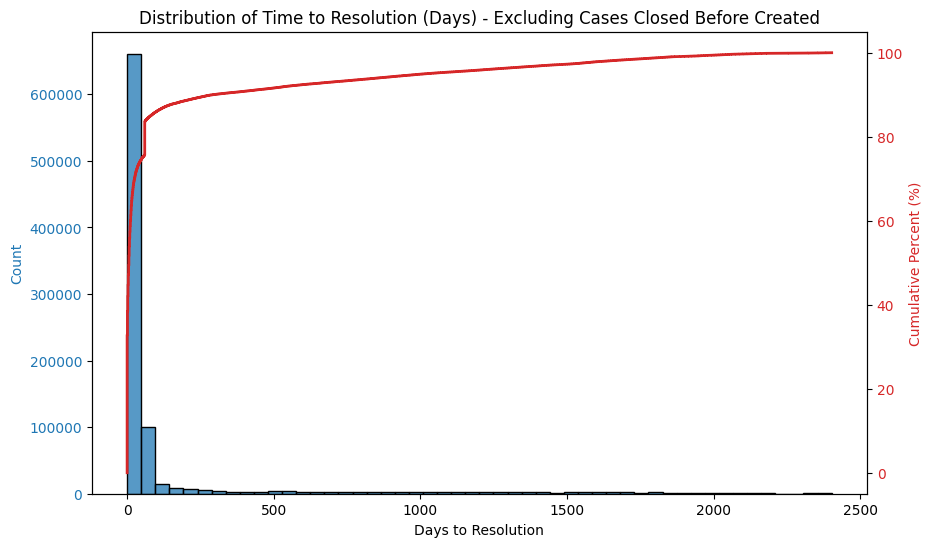

In [41]:
df_with_resolution = df_temp.dropna(subset=['closed_date', 'created_date'])

# Create histogram of time to resolution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_with_resolution, x=df_with_resolution['time_to_resolution'].dt.days, bins=50)
plt.title('Distribution of Time to Resolution (Days)')
plt.xlabel('Days to Resolution')
plt.ylabel('Count')
plt.show()

# Create plot after removing rows where closed_before_created is True
df_valid_resolution = df_with_resolution[df_with_resolution['closed_before_created'] == False]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create histogram on primary y-axis
sns.histplot(data=df_valid_resolution, x=df_valid_resolution['time_to_resolution'].dt.days, bins=50, ax=ax1)
ax1.set_xlabel('Days to Resolution')
ax1.set_ylabel('Count', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create secondary y-axis for cumulative percentage
ax2 = ax1.twinx()
days_to_resolution = df_valid_resolution['time_to_resolution'].dt.days.sort_values()
cumulative_percent = [(i / len(days_to_resolution)) * 100 for i in range(1, len(days_to_resolution) + 1)]
ax2.plot(days_to_resolution, cumulative_percent, color='tab:red', linewidth=2, label='Cumulative Percent')
ax2.set_ylabel('Cumulative Percent (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Distribution of Time to Resolution (Days) - Excluding Cases Closed Before Created')
plt.show()


In [ ]:
df_long_resolution = df_valid_resolution[df_valid_resolution['time_to_resolution'].dt.days > 365]
display(df_long_resolution['closed_date'].dt.date.value_counts(normalize=True))
df_long_resolution = df_long_resolution[(df_long_resolution['closed_date'].dt.date).isin([date(2024, 6, 3), date(2024, 6, 4)])]
df_long_resolution['resolution_description'].value_counts()


closed_date
2024-06-03    0.517976
2024-06-04    0.217189
2025-01-11    0.146887
2025-01-10    0.070027
2025-01-09    0.022345
                ...   
2023-04-28    0.000012
2023-04-11    0.000012
2023-07-06    0.000012
2024-03-19    0.000012
2025-01-13    0.000012
Name: proportion, Length: 160, dtype: float64

In [85]:
df_long_resolution = df_valid_resolution[df_valid_resolution['time_to_resolution'].dt.days > 365]
df_long_resolution['resolution_description'].value_counts()


resolution_description
This SR was administratively closed. The issue you reported was addressed.                                                                                                                                                                                    61438
The NYC Health Department has responded to your service request. For inspection results, please call (212) 676-1600 or email infobfscs@health.nyc.gov to request an inspection report. This service request has been closed.                                  14307
The NYC Health Department has investigated your complaint. You can get the status by calling 311 or (646) 632-6101 on weekdays between 9 AM and 5 PM. This service request has been closed.                                                                    5461
Thank you for your report. The Department of Health and Mental Hygiene will use the information that you provided to help track and control mosquito populations throughout the City. No further info

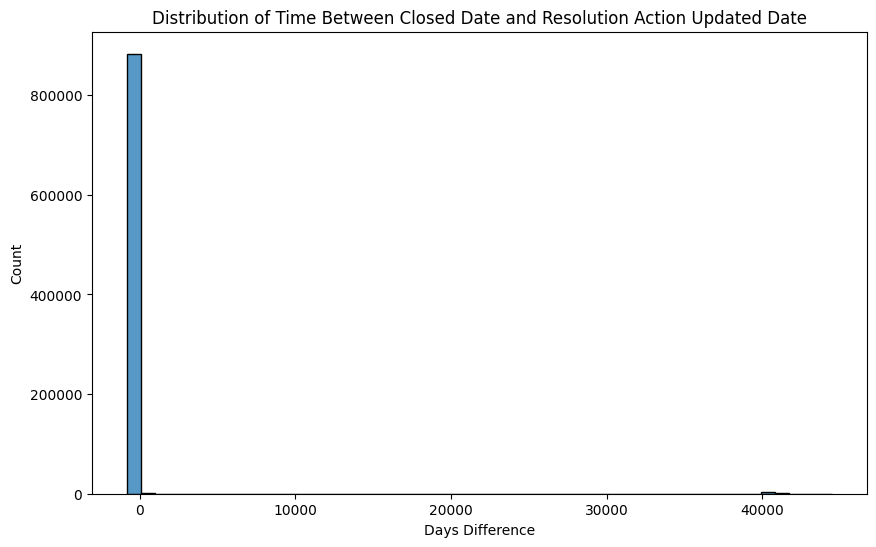

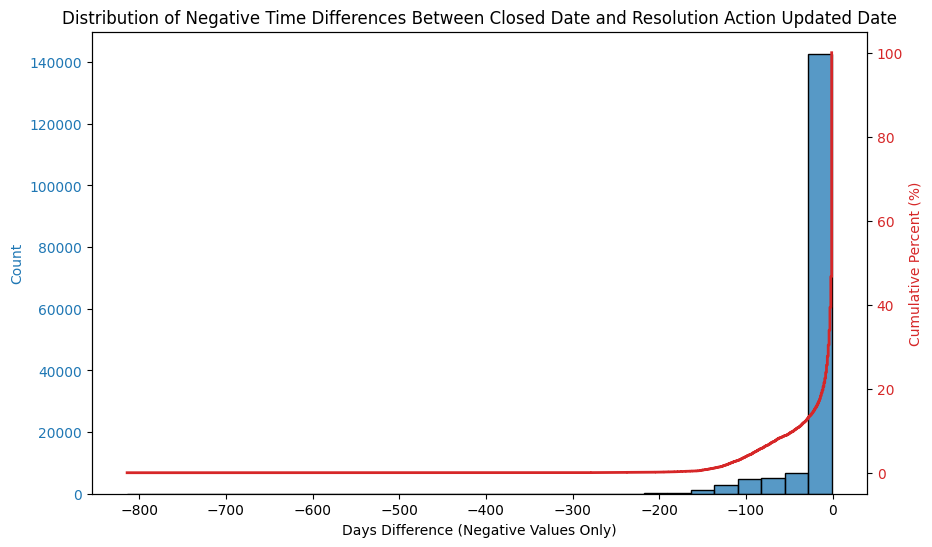

In [92]:
# Calculate time between closed_date and resolution_action_updated_date
# Remove rows where either date is NaT
df_with_update_times = df_temp.dropna(subset=['closed_date', 'resolution_action_updated_date'])

# Create histogram of time difference using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=df_with_update_times, x=df_with_update_times['time_closed_to_resolution_update'].dt.days, bins=50)
plt.title('Distribution of Time Between Closed Date and Resolution Action Updated Date')
plt.xlabel('Days Difference')
plt.ylabel('Count')
plt.show()

# Create plot with cumulative percent for negative time differences only
df_negative_times = df_with_update_times[df_with_update_times['time_closed_to_resolution_update'].dt.days < 0]
fig, ax1 = plt.subplots(figsize=(10, 6))

# Create histogram on primary y-axis
sns.histplot(data=df_negative_times, x=df_negative_times['time_closed_to_resolution_update'].dt.days, bins=30, ax=ax1)
ax1.set_xlabel('Days Difference (Negative Values Only)')
ax1.set_ylabel('Count', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create secondary y-axis for cumulative percent
ax2 = ax1.twinx()
days_negative = df_negative_times['time_closed_to_resolution_update'].dt.days.sort_values()
cumulative_percent = [(i / len(days_negative)) * 100 for i in range(1, len(days_negative) + 1)]
ax2.plot(days_negative, cumulative_percent, color='tab:red', linewidth=2, label='Cumulative Percent')
ax2.set_ylabel('Cumulative Percent (%)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Distribution of Negative Time Differences Between Closed Date and Resolution Action Updated Date')
plt.show()


In [94]:
# Analyze patterns by borough and complaint type
print("Identical created/closed dates by borough:")
print(df_temp.groupby('borough')['identical_created_closed_dates'].agg(['count', 'sum', 'mean']).round(3))

print("\nIdentical created/closed dates by complaint type:")
print(df_temp.groupby('complaint_type')['identical_created_closed_dates'].agg(['count', 'sum', 'mean']).round(3).sort_values('mean', ascending=False).head(10))

Identical created/closed dates by borough:
                count    sum   mean
borough                            
BRONX          162633  42398  0.261
BROOKLYN       322348  67569  0.210
MANHATTAN      282206  51026  0.181
QUEENS         207314  38819  0.187
STATEN ISLAND   53459  10031  0.188
Unspecified      2059      5  0.002

Identical created/closed dates by complaint type:
                                 count     sum   mean
complaint_type                                       
Pet Shop                          1275    1098  0.861
Rodent                          488764  180876  0.370
Unsanitary Pigeon Condition      12867    4653  0.362
Pet Sale                           129      43  0.333
Illegal Animal Sold               1033     326  0.316
Illegal Animal Kept as Pet        5456    1701  0.312
Unleashed Dog                    15611    4575  0.293
Unsanitary Animal Pvt Property   34422    9768  0.284
Animal Facility - No Permit       1215     256  0.211
Standing Water          

In [111]:
df_identical_dates = df_temp[df_temp['identical_created_closed_dates'] == 1]
df_identical_dates['resolution_action_updated_date'].isna().mean()

np.float64(0.0005432425864065456)

c:\Users\gorav\GitHub\nyc-311-service-requests\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128 (\x80) missing from font(s) DejaVu Sans.

c:\Users\gorav\GitHub\nyc-311-service-requests\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 153 (\x99) missing from font(s) DejaVu Sans.



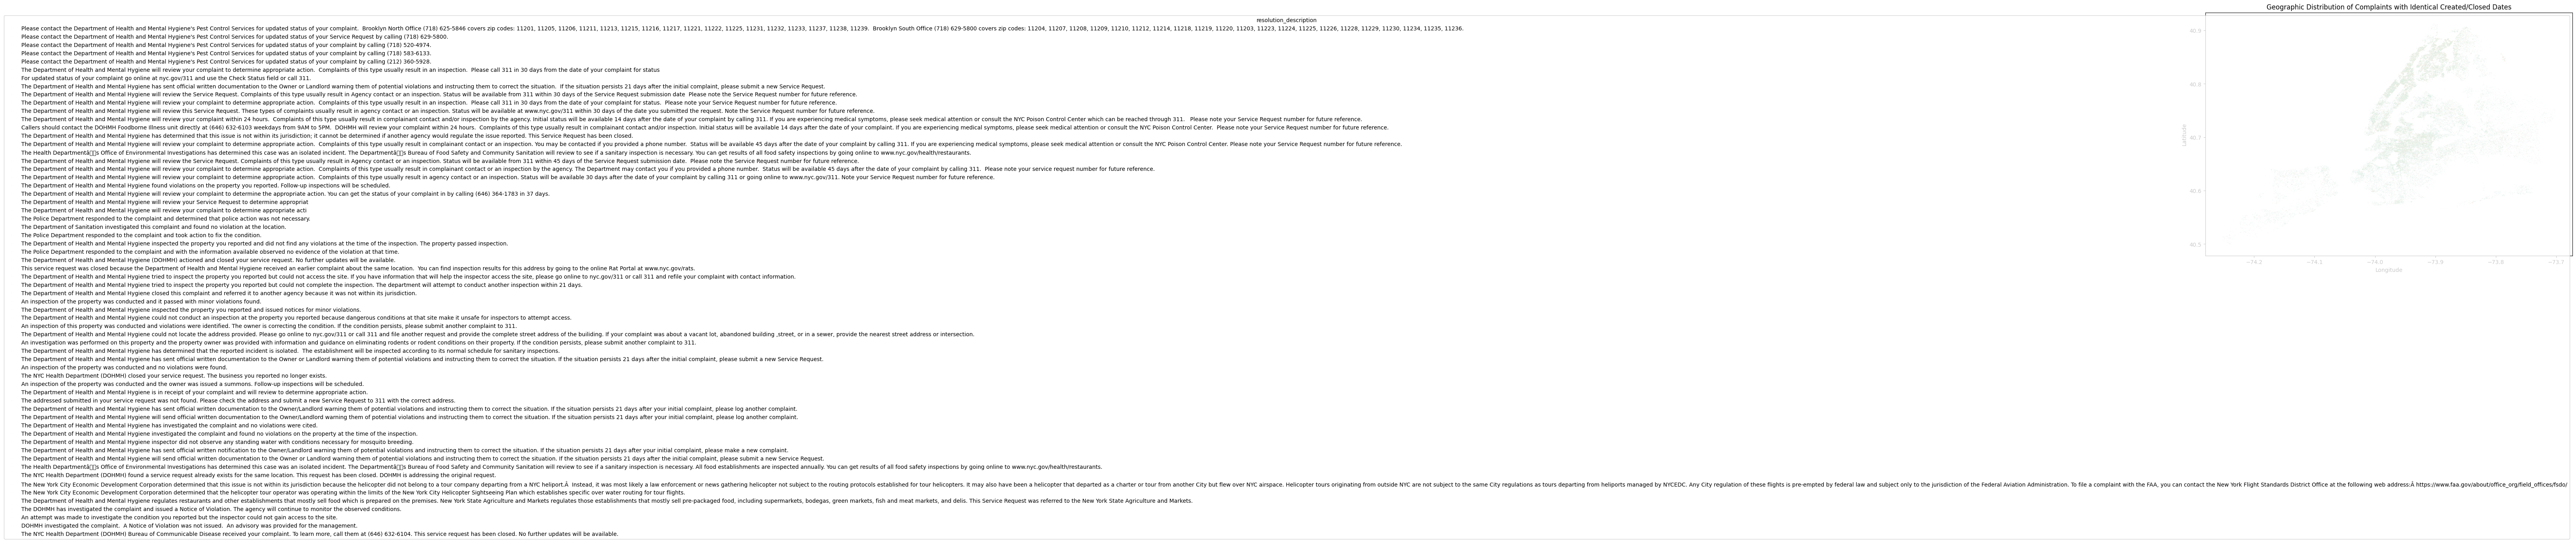

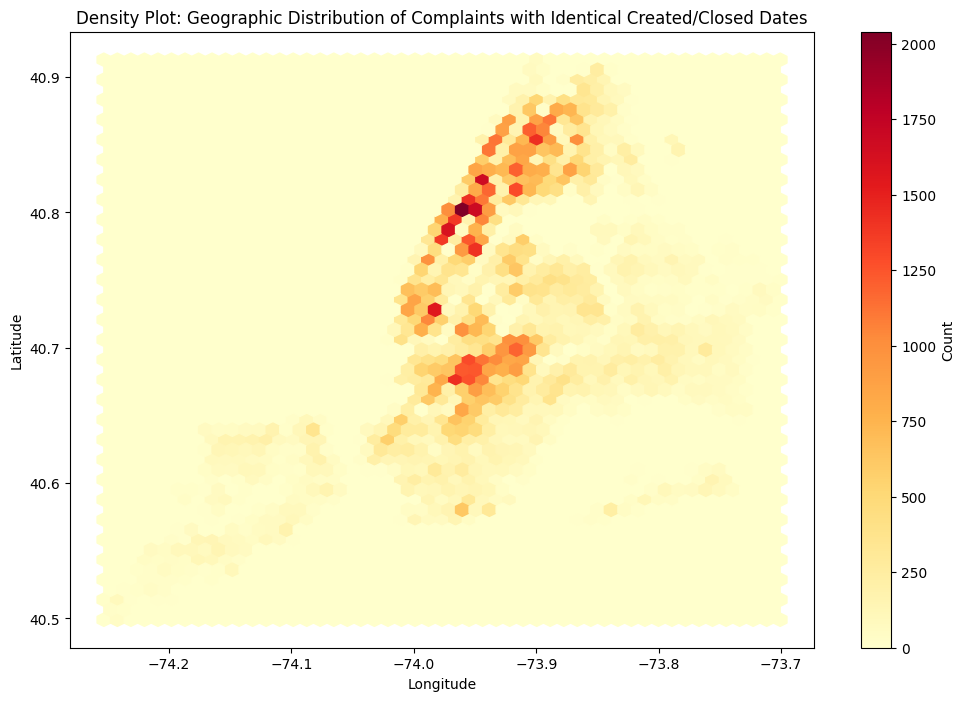

In [120]:
# Create density plot for lat/long of complaints with identical created/closed dates
df_identical_dates = df_temp[df_temp['identical_created_closed_dates'] == 1]

# Remove rows with missing lat/long values
df_plot = df_identical_dates.dropna(subset=['latitude', 'longitude'])

# Create scatter plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the complaint points
sns.scatterplot(data=df_plot, x='longitude', y='latitude', hue='resolution_description', alpha=0.1, s=1, ax=ax)
ax.set_title('Geographic Distribution of Complaints with Identical Created/Closed Dates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

# Create hexbin density plot
fig, ax = plt.subplots(figsize=(12, 8))

# Plot hexbin
hb = ax.hexbin(df_plot['longitude'], df_plot['latitude'], gridsize=50, cmap='YlOrRd')
plt.colorbar(hb, label='Count')

ax.set_title('Density Plot: Geographic Distribution of Complaints with Identical Created/Closed Dates')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [116]:
df_started_at_midnight = df_temp[df_temp['identical_created_closed_dates'] != 1]
df_started_at_midnight = df_started_at_midnight[df_started_at_midnight['created_at_midnight'] == 1]
df_started_at_midnight.groupby('closed_at_midnight')['time_to_resolution'].describe()

,count,mean,std,min,25%,50%,75%,max
closed_at_midnight,,,,,,,,
False,54738,11 days 12:58:42.290000,44 days 13:52:26.767000,-6208 days +02:03:19,1 days 16:11:07.250000,6 days 14:27:05,13 days 12:03:10.750000,1559 days 07:41:55
True,178037,13 days 00:44:04.843000,280 days 12:45:45.125000,-42872 days +00:00:00,5 days 00:00:00,9 days 00:00:00,17 days 00:00:00,1513 days 00:00:00


In [129]:
most_common_resolution_description = df_started_at_midnight[df_started_at_midnight['closed_at_midnight'] == 1]['resolution_description'].value_counts().index[0]
df_started_at_midnight[(df_started_at_midnight['closed_at_midnight'] == 1) & (df_started_at_midnight['resolution_description'] == most_common_resolution_description)]['complaint_type'].value_counts(normalize=True)

complaint_type
Rodent                            0.906120
Unsanitary Animal Pvt Property    0.071734
Unsanitary Pigeon Condition       0.022131
DPR Internal                      0.000007
DOF Literature Request            0.000007
Name: proportion, dtype: float64

In [125]:
df_started_at_midnight[df_started_at_midnight['closed_at_midnight'] == 1]['resolution_description'].value_counts(normalize=True)

resolution_description
The Department of Health and Mental Hygiene will review your complaint to determine appropriate action.  Complaints of this type usually result in an inspection.  Please call 311 in 30 days from the date of your complaint for status                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              0.784902
The Department of Health and Menta

In [122]:
df_started_at_midnight[df_started_at_midnight['closed_at_midnight'] == 1]['descriptor'].value_counts(normalize=True).cumsum()

descriptor
Rat Sighting                    0.432331
Condition Attracting Rodents    0.665805
Mouse Sighting                  0.776406
Signs of Rodents                0.835360
Other - Explain Below           0.861501
Dog                             0.885035
Swimming Pool - Unmaintained    0.903969
Pigeon Waste                    0.920348
Puddle in Ground                0.934261
Animal Waste                    0.946197
Cat                             0.957335
Animal Odor                     0.964249
Container - Over 5 Gallons      0.970085
Other Animal                    0.974359
Puddle on Roof                  0.977954
Swimming Pool Cover             0.981313
Puddle on Sidewalk              0.984537
Sewer or Drain                  0.987598
Building Foundation             0.989671
Tires                           0.991580
Puddle on Driveway              0.993097
Pigeon Odor                     0.994501
Container - Under 5 Gallons     0.995782
Roof Gutters                    0.996973
Basem

In [95]:


print("\nCreated at midnight by borough:")
print(df_temp.groupby('borough')['created_at_midnight'].agg(['count', 'sum', 'mean']).round(3))

print("\nCreated at midnight by complaint type:")
print(df_temp.groupby('complaint_type')['created_at_midnight'].agg(['count', 'sum', 'mean']).round(3).sort_values('mean', ascending=False).head(10))



Created at midnight by borough:
                count    sum   mean
borough                            
BRONX          162633  55883  0.344
BROOKLYN       322348  93057  0.289
MANHATTAN      282206  67310  0.239
QUEENS         207314  55223  0.266
STATEN ISLAND   53459  18520  0.346
Unspecified      2059    110  0.053

Created at midnight by complaint type:
                                 count     sum   mean
complaint_type                                       
DOF Literature Request               1       1  1.000
DPR Internal                         1       1  1.000
Traffic Signal Condition             1       1  1.000
Standing Water                   30015   16944  0.565
MOLD                                 2       1  0.500
Rodent                          488764  233120  0.477
Food Poisoning                   45307   20734  0.458
Unsanitary Animal Pvt Property   34422   15097  0.439
Unsanitary Pigeon Condition      12867    4202  0.327
Unlicensed Dog                      81       

In [96]:

print("\nClosed at midnight by borough:")
print(df_temp.groupby('borough')['closed_at_midnight'].agg(['count', 'sum', 'mean']).round(3))

print("\nClosed at midnight by complaint type:")
print(df_temp.groupby('complaint_type')['closed_at_midnight'].agg(['count', 'sum', 'mean']).round(3).sort_values('mean', ascending=False).head(10))


Closed at midnight by borough:
                count    sum   mean
borough                            
BRONX          162633  44575  0.274
BROOKLYN       322348  73450  0.228
MANHATTAN      282206  53740  0.190
QUEENS         207314  45122  0.218
STATEN ISLAND   53459  15830  0.296
Unspecified      2059      2  0.001

Closed at midnight by complaint type:
                                 count     sum   mean
complaint_type                                       
DOF Literature Request               1       1  1.000
DPR Internal                         1       1  1.000
Standing Water                   30015   16060  0.535
Rodent                          488764  196272  0.402
Unsanitary Animal Pvt Property   34422   11779  0.342
Unsanitary Pigeon Condition      12867    3440  0.267
Non-Residential Heat             16864    1925  0.114
Smoking                          35456    3007  0.085
Calorie Labeling                   203       7  0.034
Unlicensed Dog                      81       1 

In [ ]:
df_dohmh[df_dohmh['status'] == 'Closed'].iloc[2]['resolution_description']

In [ ]:
def map_complaints(df):
        complaint_to_family = {
        "Food Establishment": "food_safety",
        "Rodent": "vector_control",
        "Non-Residential Heat": "housing_health",
        "Food Poisoning": "food_safety",
        "Unsanitary Animal Pvt Property": "animal_control",
        "Smoking": "air_smoke_mold",
        "Indoor Air Quality": "air_smoke_mold",
        "Window Guard": "housing_health",
        "Unsanitary Pigeon Condition": "vector_control",
        "Harboring Bees/Wasps": "vector_control",
        "Asbestos": "hazmat_lead_asbestos",
        "Unleashed Dog": "animal_control",
        "Unsanitary Animal Facility": "animal_control",
        "Tattooing": "childcare_recreation",
        "Beach/Pool/Sauna Complaint": "childcare_recreation",
        "Animal Facility - No Permit": "animal_control",
        "Mold": "air_smoke_mold",
        "Portable Toilet": "misc_other",
        "Illegal Animal Kept as Pet": "animal_control",
        "Calorie Labeling": "food_safety",
        "Drinking Water": "water_quality",
        "Poison Ivy": "misc_other",
        "Illegal Animal Sold": "animal_control",
        "Bottled Water": "water_quality",
        "Radioactive Material": "hazmat_lead_asbestos",
        "Lifeguard": "childcare_recreation",
        "Trans Fat": "food_safety",
        "Summer Camp": "childcare_recreation",
        "X-Ray Machine/Equipment": "hazmat_lead_asbestos",
        "Trapping Pigeon": "vector_control",
        "Indoor Sewage": "air_smoke_mold",
        "Damaged Tree": "misc_other",
        "Unlicensed Dog": "animal_control",
        "Standing Water": "vector_control",
        "DPR Internal": "misc_other",
        "DOF Literature Request": "misc_other",
        "Animal in a Park": "animal_control",
        "Tanning": "childcare_recreation",
        "Day Care": "childcare_recreation",
        "Asbestos/Garbage Nuisance": "hazmat_lead_asbestos",
        "Mosquitoes": "vector_control",
        "LEAD": "hazmat_lead_asbestos",
        "Forms": "misc_other",
        "MOLD": "air_smoke_mold",
        "Cooling Tower": "cooling_tower",
        "Pet Shop": "animal_control",
        "Traffic Signal Condition": "misc_other",
        "Injured Wildlife": "animal_control",
        "Illegal Animal - Sold/Kept": "animal_control",
        "Mobile Food Vendor": "food_safety",
        "Construction Lead Dust": "hazmat_lead_asbestos",
        "Peeling Paint": "hazmat_lead_asbestos",
        "Vaccine Mandate Non-Compliance": "tobacco_enforcement",
        "Face Covering Violation": "tobacco_enforcement",
        "Private School Vaccine Mandate Non-Compliance": "tobacco_enforcement",
        "Building Drinking Water Tank": "water_quality",
        "Smoking or Vaping": "air_smoke_mold",
        "Tobacco or Non-Tobacco Sale": "tobacco_enforcement",
        "ASBESTOS": "hazmat_lead_asbestos",
        "Pet Sale": "animal_control",
        "Lost Property": "misc_other",
        }

        # Optional family -> skill tag used in staffing
        family_to_skill = {
        "food_safety": "food",
        "vector_control": "vector",
        "air_smoke_mold": "ieq",
        "hazmat_lead_asbestos": "hazmat",
        "water_quality": "water",
        "cooling_tower": "legionella",
        "animal_control": "animal",
        "childcare_recreation": "community_env",
        "tobacco_enforcement": "enforcement",
        "housing_health": "community_env",
        "misc_other": "generalist",
        }

        # Apply to your dataframe `df`
        df = df.copy()
        df["family"] = df["complaint_type"].map(complaint_to_family)
        df["skill_tag"] = df["family"].map(family_to_skill)

        return df

# TODO:
1. Create a mapping for the output from resolution_description
2. Create a mapping for the output from descriptor
3. Drop excesivly long ticket when it comes to duration
4. Drop data were created and closed date is the same because we can't tell when the service request was opened, we can't tell the duration or anything else
5.